# Imports

In [108]:
#!pip install xgboost

In [106]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
# import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as Pipeline_imb

from imblearn.combine import SMOTETomek

from imblearn.over_sampling import SMOTE
# from xgboost import XGBClassifier

In [44]:
# test = pd.read_csv('../datasets/test.csv', parse_dates=['Date'],index_col=['Id'])
train = pd.read_csv("../datasets/final_train.csv")
test = pd.read_csv("../datasets/final_test.csv", index_col='id')

# Run_Model Function

In [159]:
def run_model(clsf, params, kind='reg'):
    
    """ Input classifier, parameters, and 
    kind ('reg' (default), 'pca', 'smote',or 'smotetomek') """

    if kind == 'reg':
        pipe = Pipeline([
            ('sc', StandardScaler()),
            ('clsf', clsf)
        ])

    if kind == 'smote':
        pipe = Pipeline_imb([
            ('sc', StandardScaler()),
            ('smpl', SMOTE(sampling_strategy='auto', random_state=42)),
            ('clsf', clsf)
        ])
        
    if kind == 'smotetomek':
        pipe = Pipeline_imb([
            ('sc', StandardScaler()),
            ('smpl', SMOTETomek(random_state=42)),
            ('clsf', clsf)
        ])

    if kind == 'pca':
        pipe = Pipeline([
            ('sc', StandardScaler()),
            ('pca', PCA(n_components=50, random_state=42)),
            ('clsf', clsf)
        ])

    grid = GridSearchCV(
        pipe,
        param_grid=params,
        scoring='roc_auc',
        cv=4,
        n_jobs=-1,
        verbose=2)

    if kind in ['reg', 'smote', 'smotetomek']:
        grid.fit(X_train, y_train)
        pred = grid.predict(X_test)
        pred_prob = grid.predict_proba(X_test)[:, 1]

    elif kind == 'pca':
        grid.fit(Xp_train, y_train)
        pred = grid.predict(Xp_test)
        pred_prob = grid.predict_proba(Xp_test)[:, 1] 
        
    else:
        print("Try again")
        return

    table = {'Model': clsf}
    table['Type'] = kind

    table['ROC-AUC'] = roc_auc_score(y_test, pred_prob)
    table['Precision'] = precision_score(y_test, pred)
    table['Recall'] = recall_score(y_test, pred)
    table['F1'] = f1_score(y_test, pred)
    
    for key, value in grid.best_params_.items():
        table[key] = value

    
    print('\n')
    print('='*30)
    print(f"\033[1m {clsf} \033[0m".center(38, "="))
    print('='*30)
    print('')
    print(" Best Parameters:")
    print('-'*30, '\n')
    for key, value in grid.best_params_.items():
        print(key, ':', value)

    print(confusion_matrix(y_test, pred))
    scoring_table.append(table)
    return grid

In [76]:
def submit_kaggle(name, gs):
    """ the function takes filename and gs best estimator,
    and creates a csv file ready for kaggle's WestNile competition
    """
    
    submit= pd.DataFrame()
    submit['Id'] = test.index
    submit.set_index('Id', drop=True,inplace=True)
    submit['WnvPresent'] =gs.predict_proba(test)[:,1]
    submit.to_csv(f'../datasets/{name}2.csv')

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8475 non-null   object 
 1   species            8475 non-null   object 
 2   latitude           8475 non-null   float64
 3   longitude          8475 non-null   float64
 4   latlong            8475 non-null   object 
 5   nummosquitos       8475 non-null   int64  
 6   wnvpresent         8475 non-null   int64  
 7   year               8475 non-null   int64  
 8   dum_species        8475 non-null   int64  
 9   tavg               8475 non-null   float64
 10  preciptotal        8475 non-null   float64
 11  stnpressure        8475 non-null   float64
 12  sealevel           8475 non-null   float64
 13  resultspeed        8475 non-null   float64
 14  resultdir          8475 non-null   float64
 15  avgspeed           8475 non-null   float64
 16  humidity           8475 

In [47]:
train.describe()

,latitude,longitude,nummosquitos,wnvpresent,year,dum_species,tavg,preciptotal,stnpressure,sealevel,...,dumweek_30,dumweek_31,dumweek_32,dumweek_33,dumweek_34,dumweek_35,dumweek_36,dumweek_37,dumweek_38,dumweek_39
count,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,...,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000
mean,41.844618,-87.694788,15.933805,0.053923,2009.713156,1.246254,22.460505,0.156117,29.281345,29.961765,...,0.066903,0.094395,0.070678,0.070324,0.078938,0.041298,0.040472,0.056755,0.071504,0.049794
std,0.106609,0.084063,75.084707,0.225880,2.331751,0.507795,4.217497,0.339540,0.116693,0.120210,...,0.249868,0.292395,0.256302,0.255708,0.269658,0.198990,0.197075,0.231388,0.257681,0.217531
min,41.644612,-87.930995,1.000000,0.000000,2007.000000,0.000000,10.555556,0.000000,28.920000,29.595000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.750498,-87.752329,2.000000,0.000000,2007.000000,1.000000,20.277778,0.000000,29.200000,29.880000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.857402,-87.694991,4.000000,0.000000,2009.000000,1.000000,23.055556,0.000000,29.290000,29.970000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,41.944869,-87.642984,11.000000,0.000000,2011.000000,2.000000,25.277778,0.165000,29.370000,30.050000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,42.017430,-87.531635,2532.000000,1.000000,2013.000000,2.000000,29.722222,2.420000,29.620000,30.330000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
test.head()

,date,species,latitude,longitude,year,latlong,dum_species,tavg,preciptotal,stnpressure,...,dumweek_30,dumweek_31,dumweek_32,dumweek_33,dumweek_34,dumweek_35,dumweek_36,dumweek_37,dumweek_38,dumweek_39
id,,,,,,,,,,,,,,,,,,,,,
1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,2008,"41.95469, -87.800991",1,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,2008,"41.95469, -87.800991",2,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,2008,"41.95469, -87.800991",1,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,2008,"41.95469, -87.800991",0,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,2008,"41.95469, -87.800991",0,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0


In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8475 non-null   object 
 1   species            8475 non-null   object 
 2   latitude           8475 non-null   float64
 3   longitude          8475 non-null   float64
 4   latlong            8475 non-null   object 
 5   nummosquitos       8475 non-null   int64  
 6   wnvpresent         8475 non-null   int64  
 7   year               8475 non-null   int64  
 8   dum_species        8475 non-null   int64  
 9   tavg               8475 non-null   float64
 10  preciptotal        8475 non-null   float64
 11  stnpressure        8475 non-null   float64
 12  sealevel           8475 non-null   float64
 13  resultspeed        8475 non-null   float64
 14  resultdir          8475 non-null   float64
 15  avgspeed           8475 non-null   float64
 16  humidity           8475 

In [51]:
test.head()

,date,species,latitude,longitude,year,latlong,dum_species,tavg,preciptotal,stnpressure,...,dumweek_30,dumweek_31,dumweek_32,dumweek_33,dumweek_34,dumweek_35,dumweek_36,dumweek_37,dumweek_38,dumweek_39
id,,,,,,,,,,,,,,,,,,,,,
1,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,2008,"41.95469, -87.800991",1,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
2,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,2008,"41.95469, -87.800991",2,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
3,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,2008,"41.95469, -87.800991",1,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
4,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,2008,"41.95469, -87.800991",0,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0
5,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,2008,"41.95469, -87.800991",0,23.888889,0.0,29.31,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X = train.drop(['wnvpresent','date','species', 'latlong', 'nummosquitos', 'year'], axis=1)
y = train['wnvpresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [53]:
scoring_table=[]

In [55]:
test.shape

(116293, 32)

In [69]:
set(test.columns)-set(X_test.columns)

{'date', 'latlong', 'species', 'year'}

In [70]:
test.drop(columns=['date', 'latlong', 'species', 'year'], inplace=True)

# Models

## Random Forest

In [57]:
rf = RandomForestClassifier(random_state=42, n_jobs=4)

params_rf = {
    'clsf__n_estimators': [ 200,300],
    'clsf__max_depth': [ 7,10],
    'clsf__ccp_alpha':[0, 0.01]
}



In [58]:
gs = run_model(rf, params_rf)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


 RandomForestClassifier(n_jobs=4, random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__max_depth : 10
clsf__n_estimators : 300
[[2003    2]
 [ 108    6]]


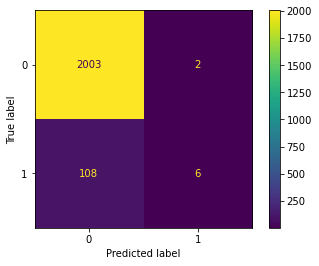

In [59]:
plot_confusion_matrix(gs, X_test, y_test)

In [60]:
scoring_table

[{'Model': RandomForestClassifier(n_jobs=4, random_state=42),
  'Type': 'reg',
  'ROC-AUC': 0.8560812880080502,
  'Precision': 0.75,
  'Recall': 0.05263157894736842,
  'F1': 0.09836065573770492,
  'clsf__ccp_alpha': 0,
  'clsf__max_depth': 10,
  'clsf__n_estimators': 300}]

In [77]:
submit_kaggle('submit_rf', gs)

###  RandomForest Kaggle

<img  src="../images/submit_rf2.png">

## Gradient Boost

In [61]:
# Gradient Boost
gb = GradientBoostingClassifier(random_state=42)

params_gb = {
    'clsf__learning_rate': [ 0.01, 0.1],
    'clsf__max_depth': [7, 10],
    'clsf__ccp_alpha':[0, 0.1],
    'clsf__n_estimators':[200, 350]
}

In [62]:
gs_gb=run_model(gb, params_gb)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


 GradientBoostingClassifier(random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__learning_rate : 0.01
clsf__max_depth : 7
clsf__n_estimators : 350
[[1995   10]
 [ 103   11]]


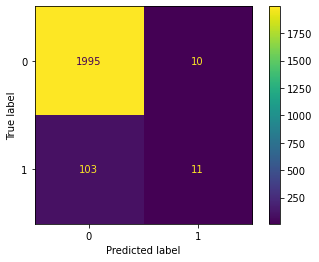

In [64]:
plot_confusion_matrix(gs_gb, X_test, y_test)

In [65]:
pd.DataFrame(scoring_table).sort_values(by='ROC-AUC', ascending=False)

,Model,Type,ROC-AUC,Precision,Recall,F1,clsf__ccp_alpha,clsf__max_depth,clsf__n_estimators,clsf__learning_rate
0,"RandomForestClassifier(n_jobs=4, random_state=42)",reg,0.856081,0.75000,0.052632,0.098361,0,10,300,NaN
1,GradientBoostingClassifier(random_state=42),reg,0.835177,0.52381,0.096491,0.162963,0,7,350,0.01


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('clsf',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=4,
             param_grid={'clsf__ccp_alpha': [0, 0.01],
                         'clsf__max_depth': [7, 10],
                         'clsf__n_estimators': [200, 300]},
             scoring='roc_auc', verbose=3)

In [ ]:
submit_kaggle('submit_gb', gs_gb)

###  GradientBoost Kaggle

<img  src="../images/submit_gb.png">

In [110]:
scoring_table

[{'Model': GradientBoostingClassifier(random_state=42),
  'ROC-AUC': 0.8305639410246313,
  'Precision': 0.2911392405063291,
  'Recall': 0.20175438596491227,
  'F1': 0.23834196891191708},
 {'Model': RandomForestClassifier(n_jobs=4, random_state=42),
  'ROC-AUC': 0.8626110163188518,
  'Precision': 0.0,
  'Recall': 0.0,
  'F1': 0.0}]

# PCA model setup

In [149]:
# Poly by power of 2.  
pf = PolynomialFeatures(degree=2, include_bias=True, interaction_only=True )  
# Fit and transform our X data using Polynomial Features.  
X_poly = pf.fit_transform(X)

#transform the real (Kaggle) test set
test_poly = pf.transform(test)
                         
#Train/test split our data.
Xp_train, Xp_test, y_train, y_test = train_test_split(X_poly,
                                                            y,
                                                            stratify=y,
                                                            random_state=42)      

# Instantiate our StandardScaler.
sc = StandardScaler()
# Scale X_train.
Xp_trainsc = sc.fit_transform(Xp_train)
# Scale X_test.
Xp_testsc = sc.transform(Xp_test)
# Scale the real Kaggle test set
testsc = sc.transform(test_poly)

In [179]:
pf.get_feature_names(X.columns)

['1',
 'latitude',
 'longitude',
 'dum_species',
 'tavg',
 'preciptotal',
 'stnpressure',
 'sealevel',
 'resultspeed',
 'resultdir',
 'avgspeed',
 'humidity',
 'daylength',
 'tavg_lag14',
 'humidity_lag14',
 'resultspeed_lag14',
 'preciptotal_lag14',
 'dumweek_28',
 'dumweek_29',
 'dumweek_30',
 'dumweek_31',
 'dumweek_32',
 'dumweek_33',
 'dumweek_34',
 'dumweek_35',
 'dumweek_36',
 'dumweek_37',
 'dumweek_38',
 'dumweek_39',
 'latitude longitude',
 'latitude dum_species',
 'latitude tavg',
 'latitude preciptotal',
 'latitude stnpressure',
 'latitude sealevel',
 'latitude resultspeed',
 'latitude resultdir',
 'latitude avgspeed',
 'latitude humidity',
 'latitude daylength',
 'latitude tavg_lag14',
 'latitude humidity_lag14',
 'latitude resultspeed_lag14',
 'latitude preciptotal_lag14',
 'latitude dumweek_28',
 'latitude dumweek_29',
 'latitude dumweek_30',
 'latitude dumweek_31',
 'latitude dumweek_32',
 'latitude dumweek_33',
 'latitude dumweek_34',
 'latitude dumweek_35',
 'latitude

In [182]:
new = pd.DataFrame(Xp_trainsc, columns = pf.get_feature_names(X.columns))

In [183]:
new.head()

,1,latitude,longitude,dum_species,tavg,preciptotal,stnpressure,sealevel,resultspeed,resultdir,...,dumweek_35 dumweek_36,dumweek_35 dumweek_37,dumweek_35 dumweek_38,dumweek_35 dumweek_39,dumweek_36 dumweek_37,dumweek_36 dumweek_38,dumweek_36 dumweek_39,dumweek_37 dumweek_38,dumweek_37 dumweek_39,dumweek_38 dumweek_39
0,0.0,-1.602313,1.133388,-0.489074,-1.122594,-0.464266,-1.514397,-1.681249,1.036524,1.236051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.946417,-0.430646,1.493423,0.790436,1.525244,-0.046916,-0.090089,1.018858,0.507860,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.120524,0.040384,-0.489074,0.658503,-0.464266,0.255212,0.286764,-1.242348,0.563875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.879923,1.068817,-0.489074,1.054303,-0.464266,0.298373,0.244892,-1.136354,-0.780478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.263587,-0.662482,-0.489074,1.054303,-0.464266,0.298373,0.244892,-1.136354,-0.780478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
new.corrwith(y_train).dropna().sort_values()[:10]

resultspeed humidity         -0.048481
resultspeed humidity_lag14   -0.045561
resultspeed                  -0.041324
latitude resultspeed         -0.041271
sealevel resultspeed         -0.041232
stnpressure resultspeed      -0.041224
humidity resultspeed_lag14   -0.040749
dum_species resultspeed      -0.039273
resultspeed daylength        -0.039261
avgspeed humidity            -0.038062
dtype: float64

In [189]:
new.corrwith(y_train).dropna().sort_values(ascending=False)[:10]

tavg_lag14 dumweek_35     0.042380
tavg dumweek_35           0.042053
longitude resultspeed     0.041301
resultdir dumweek_35      0.039605
latitude dumweek_35       0.034497
dumweek_35                0.034483
stnpressure dumweek_35    0.034364
sealevel dumweek_35       0.034355
daylength dumweek_35      0.033983
latitude stnpressure      0.033611
dtype: float64

In [152]:
# Instantiate PCA.
pca = PCA(random_state=42)

# Fit and transform PCA for train, transform for test
Z_train = pca.fit_transform(Xp_trainsc)

Z_test = pca.transform(Xp_testsc)
Z_kaggle_test = pca.transform(testsc)


In [154]:
expl_var = np.cumsum(pca.explained_variance_ratio_)[:90]

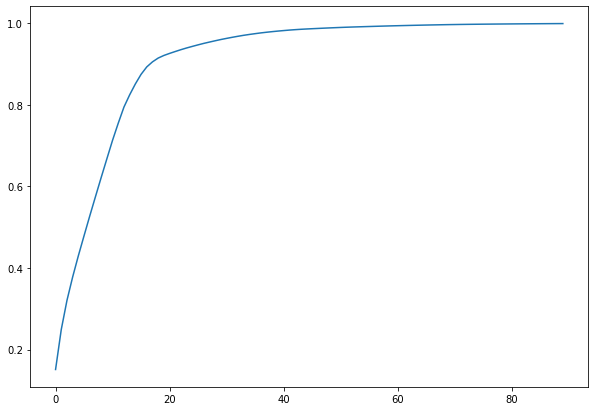

In [155]:
plt.figure(figsize=(10,7))
plt.plot(range(len(expl_var)), expl_var)
plt.show()

In [158]:
expl_var[50]

0.9893366557127165

# Gradient Boost, w/ poly features+PCA

In [160]:
params_gb

{'clsf__learning_rate': [0.01, 0.1],
 'clsf__max_depth': [7, 10],
 'clsf__ccp_alpha': [0, 0.1],
 'clsf__n_estimators': [200, 350]}

In [161]:
gs_gb_pca=run_model(gb, params_gb, 'pca')

Fitting 4 folds for each of 16 candidates, totalling 64 fits


 GradientBoostingClassifier(random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__learning_rate : 0.01
clsf__max_depth : 7
clsf__n_estimators : 350
[[1981   24]
 [  99   15]]


In [162]:
submit_gb_pca = pd.DataFrame()
submit_gb_pca['Id'] = test.index
submit_gb_pca.set_index('Id', drop=True,inplace=True)
submit_gb_pca['WnvPresent'] =gs_gb_pca.predict_proba(test_poly)[:,1]
submit_gb_pca.to_csv('../datasets/submit_gb_pca2.csv')

###  Gradient Boost w/smote Kaggle

<img src="../images/submit_gbpca.png" alt="not great">

## LogReg, w/ poly features + PCA

In [225]:
lr = LogisticRegression(
    solver='liblinear',
    random_state=42,
)

params_lr = {
    'clsf__penalty': ['l1'],
    'clsf__C': [0.1, 1.5],
    'clsf__max_iter': [200]
}

pipe_lrpca = Pipeline_imb([
            ('pf', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True )),
            ('sc', StandardScaler()),
            ('pca', PCA(n_components=50, random_state=42)),
            ('smpl', SMOTE(sampling_strategy='auto', random_state=42)),
            ('clsf', lr)
        ])



In [226]:
  grid_lrpca = GridSearchCV(
        pipe_lrpca,
        param_grid=params_lr,
        scoring='roc_auc',
        cv=4,
        n_jobs=-1,
        verbose=2)

In [227]:
grid_lrpca.fit(X_train, y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pf',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('sc', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=50, random_state=42)),
                                       ('smpl', SMOTE(random_state=42)),
                                       ('clsf',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clsf__C': [0.1, 1.5], 'clsf__max_iter': [200],
                         'clsf__penalty': ['l1']},
             scoring='roc_auc', verbose=2)

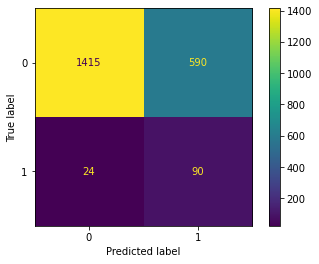

In [228]:
plot_confusion_matrix(grid_lrpca, X_test, y_test)

In [229]:
pred = grid_lrpca.predict(X_test)
pred_prob = grid_lrpca.predict_proba(X_test)[:, 1]

table = {'Model': lr}
table['Type'] = 'pcasmote'
table['ROC-AUC'] = roc_auc_score(y_test, pred_prob)
table['Precision'] = precision_score(y_test, pred)
table['Recall'] = recall_score(y_test, pred)
table['F1'] = f1_score(y_test, pred)

for key, value in grid_lrpca.best_params_.items():
        table[key] = value

scoring_table.append(table)

In [211]:
submit_kaggle('submit_lrpca', grid_lrpca)

###  LogReg w/smote and PCA Kaggle

<img src="../images/submit_lrpcasmote.png" alt="not great">

# Random Forest w/smotetek and PCA

In [216]:
rf = RandomForestClassifier(
    random_state=42,
)

params_rfpca = {
    'clsf__n_estimators': [ 200,300],
    'clsf__max_depth': [ 7,10],
    'clsf__min_samples_leaf':[4,10]
}


pipe_rfpca = Pipeline_imb([
            ('pf', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True )),
            ('sc', StandardScaler()),
            ('pca', PCA(n_components=50, random_state=42)),
            ('smpl', SMOTETomek(random_state=42)),
            ('clsf', rf)
        ])

In [217]:
grid_rfpca = GridSearchCV(
        pipe_rfpca,
        param_grid=params_rfpca,
        scoring='roc_auc',
        cv=4,
        n_jobs=-1,
        verbose=2)

In [218]:
grid_rfpca.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pf',
                                        PolynomialFeatures(interaction_only=True)),
                                       ('sc', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=50, random_state=42)),
                                       ('smpl', SMOTETomek(random_state=42)),
                                       ('clsf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clsf__max_depth': [7, 10],
                         'clsf__min_samples_leaf': [4, 10],
                         'clsf__n_estimators': [200, 300]},
             scoring='roc_auc', verbose=2)

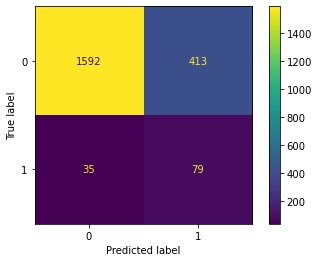

In [220]:
plot_confusion_matrix(grid_rfpca, X_test, y_test)

In [221]:
submit_kaggle('submit_rfpca', grid_rfpca)

###  Random Forest w/smote and pca50 Kaggle

<img src="../images/submit_rfsmotepca.png" alt="not great">

In [223]:
pred = grid_rfpca.predict(X_test)
pred_prob = grid_rfpca.predict_proba(X_test)[:, 1]

table = {'Model': rf}
table['Type'] = 'pcasmote'
table['ROC-AUC'] = roc_auc_score(y_test, pred_prob)
table['Precision'] = precision_score(y_test, pred)
table['Recall'] = recall_score(y_test, pred)
table['F1'] = f1_score(y_test, pred)

for key, value in grid_rfpca.best_params_.items():
        table[key] = value

scoring_table.append(table)

# Log Reg w/SMOTE

In [78]:
lr = LogisticRegression(
    solver='liblinear',
    random_state=42,
)

params_lr_smote = {
    'clsf__penalty': ['l1', 'l2'],
    'clsf__C': [0.1, 1.5, 10, 40],
    'clsf__max_iter': [50, 200, 1000],
    'smpl__k_neighbors': [3, 5, 7],
}

In [79]:
gs_lr_smote = run_model(lr, params_lr_smote, 'smote')

Fitting 4 folds for each of 72 candidates, totalling 288 fits


 LogisticRegression(random_state=42, solver='liblinear') 

 Best Parameters:
------------------------------ 

clsf__C : 0.1
clsf__max_iter : 50
clsf__penalty : l2
smpl__k_neighbors : 5
[[1323  682]
 [  18   96]]


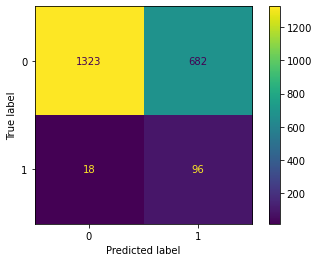

In [80]:
plot_confusion_matrix(gs_lr_smote, X_test, y_test)

In [81]:
pd.DataFrame(scoring_table)

,Model,Type,ROC-AUC,Precision,Recall,F1,clsf__ccp_alpha,clsf__max_depth,clsf__n_estimators,clsf__learning_rate,clsf__C,clsf__max_iter,clsf__penalty,smpl__k_neighbors
0,"RandomForestClassifier(n_jobs=4, random_state=42)",reg,0.856081,0.750000,0.052632,0.098361,0.0,10.0,300.0,NaN,NaN,NaN,NaN,NaN
1,GradientBoostingClassifier(random_state=42),reg,0.835177,0.523810,0.096491,0.162963,0.0,7.0,350.0,0.01,NaN,NaN,NaN,NaN
2,"LogisticRegression(random_state=42, solver='li...",smote,0.811014,0.123393,0.842105,0.215247,NaN,NaN,NaN,NaN,0.1,50.0,l2,5.0


In [462]:
pd.DataFrame(scoring_table)

,Model,Type,ROC-AUC,Precision,Recall,F1,clsf__ccp_alpha,clsf__max_depth,clsf__n_estimators,clsf__learning_rate,clsf__C,clsf__max_iter,clsf__penalty,smpl__k_neighbors,smpl__sampling_strategy
0,"RandomForestClassifier(n_jobs=4, random_state=42)",reg,0.862611,0.000000,0.000000,0.000000,0.0,7.0,300.0,NaN,NaN,NaN,NaN,NaN,NaN
1,GradientBoostingClassifier(random_state=42),reg,0.830564,0.291139,0.201754,0.238342,0.0,7.0,200.0,0.10,NaN,NaN,NaN,NaN,NaN
2,GradientBoostingClassifier(random_state=42),pca,0.835033,0.480000,0.105263,0.172662,0.0,7.0,350.0,0.01,NaN,NaN,NaN,NaN,NaN
3,"LogisticRegression(random_state=42, solver='li...",pca,0.783445,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,10.0,50.0,l2,NaN,NaN
4,"LogisticRegression(random_state=42, solver='sa...",pca,0.783388,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,40.0,1000.0,l2,NaN,NaN
5,"LogisticRegression(random_state=42, solver='li...",smote,0.782898,0.113842,0.771930,0.198422,NaN,NaN,NaN,NaN,0.1,50.0,l1,5.0,minority
6,GradientBoostingClassifier(random_state=42),smote,0.843306,0.223350,0.385965,0.282958,0.0,7.0,150.0,0.10,NaN,NaN,NaN,NaN,NaN


In [82]:
submit_kaggle('submit_lr_smote', gs_lr_smote)

###  LogReg w/smote Kaggle

<img src="../images/submit_lrsmote2.png" alt="not great">

# Gradient boost w/SMOTE


In [94]:
gb = GradientBoostingClassifier(random_state=42)

params_gb_smote = {
    'clsf__learning_rate': [ 0.05, 0.1],
    'clsf__max_depth': [7, 10],
    'clsf__ccp_alpha':[0, 0.01],
    'clsf__n_estimators':[150, 300],
    'smpl__k_neighbors': [3, 5, 7],
}

In [95]:
gs_gb_smote = run_model(gb, params_gb_smote, 'smote')

Fitting 4 folds for each of 16 candidates, totalling 64 fits


 GradientBoostingClassifier(random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__learning_rate : 0.05
clsf__max_depth : 7
clsf__n_estimators : 150
[[1763  242]
 [  57   57]]


In [87]:
submit_kaggle('submit_gb_smote', gs_gb_smotetomek)

### Gradient Boost w/smote Kaggle

<img src="../images/submit_gbsmote.png" alt="not great">

In [99]:
gb = GradientBoostingClassifier(random_state=42)

params_gb_smotetomek = {
    'clsf__learning_rate': [0.025, 0.05],
    'clsf__max_depth': [7, 10],
    'clsf__ccp_alpha':[0, 0.01],
    'clsf__n_estimators':[150, 250],
    'smpl__sampling_strategy':['all', 'auto']
}

In [100]:
gs_gb_smotetomek = run_model(gb, params_gb_smotetomek, 'smotetomek')

Fitting 4 folds for each of 32 candidates, totalling 128 fits


 GradientBoostingClassifier(random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__learning_rate : 0.05
clsf__max_depth : 7
clsf__n_estimators : 150
smpl__sampling_strategy : all
[[1756  249]
 [  53   61]]


In [98]:
submit_kaggle('submit_gbsmotetomek', gs_gb_smotetomek)

### Gradient boost w/smotetomek Kaggle

<img src="../images/submit_gbsmotetomek.png" alt="not great">

## Random Forest w/smote

In [101]:
rf = RandomForestClassifier(random_state=42, n_jobs=4)

params_rf_smote = {
    'clsf__n_estimators': [150, 250],
    'clsf__max_depth': [ 5, 7],
    'clsf__ccp_alpha':[0, 0.01],
    'smpl__k_neighbors': [3, 5, 7],
}

In [102]:
gs_rf_smote = run_model(rf, params_rf_smote, 'smote')

Fitting 4 folds for each of 24 candidates, totalling 96 fits


 RandomForestClassifier(n_jobs=4, random_state=42) 

 Best Parameters:
------------------------------ 

clsf__ccp_alpha : 0
clsf__max_depth : 7
clsf__n_estimators : 250
smpl__k_neighbors : 5
[[1429  576]
 [  24   90]]


In [103]:
submit_kaggle('rf_smote', gs_rf_smote)

### Random Forest w/smote Kaggle

<img src="../images/submit_rfsmote2.png" alt="not great">

## XGboost w smotetomek

In [116]:
xg_smotetomek = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    objective='binary:logistic',
    random_state=42,
)

xg_smotetomek_params = { 
    'clsf__max_depth': [3, 5],
    'clsf__gamma' : [0.15, 0.25],
    'clsf__learning_rate' : [0.125, 0.2],
    'clsf__n_estimators':[150, 200],
    'clsf__reg_alpha':[5,10],
    'smpl__sampling_strategy':['all', 'auto', 'not minority']
}

In [117]:
gs_xg_smotetomek = run_model(xg_smotetomek, xg_smotetomek_params, kind='smotetomek')

Fitting 4 folds for each of 8 candidates, totalling 32 fits


 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None) 

 Best Parameters:
------------------------------ 

clsf__gamma : 0.15
clsf__learning_rate : 0.125
clsf__max_depth : 5
clsf__n_estimators : 150
clsf__reg_alpha : 10
smpl__sampling_strategy : all

In [118]:
submit_kaggle('submit_xgsmotetomek', gs_xg_smotetomek)

### XGBoost w/smote Kaggle

<img src="../images/submit_xgsmotetomek.png" alt="not great">

In [231]:
# del scoring_table[8]

In [237]:
Table = pd.DataFrame(scoring_table)
Table

,Model,Type,ROC-AUC,Precision,Recall,F1,clsf__ccp_alpha,clsf__max_depth,clsf__n_estimators,clsf__learning_rate,clsf__C,clsf__max_iter,clsf__penalty,smpl__k_neighbors,smpl__sampling_strategy,clsf__gamma,clsf__reg_alpha,clsf__min_samples_leaf,Kaggle_AUC
0,"RandomForestClassifier(n_jobs=4, random_state=42)",reg,0.856081,0.750000,0.052632,0.098361,0.0,10.0,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712
1,GradientBoostingClassifier(random_state=42),reg,0.835177,0.523810,0.096491,0.162963,0.0,7.0,350.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.718
2,"LogisticRegression(random_state=42, solver='li...",smote,0.811014,0.123393,0.842105,0.215247,NaN,NaN,NaN,NaN,0.1,50.0,l2,5.0,NaN,NaN,NaN,NaN,0.685
3,GradientBoostingClassifier(random_state=42),smote,0.835501,0.190635,0.500000,0.276029,0.0,7.0,150.0,0.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.697
4,GradientBoostingClassifier(random_state=42),smotetomek,0.837258,0.196774,0.535088,0.287736,0.0,7.0,150.0,0.050,NaN,NaN,NaN,NaN,all,NaN,NaN,NaN,0.700
5,"RandomForestClassifier(n_jobs=4, random_state=42)",smote,0.829269,0.135135,0.789474,0.230769,0.0,7.0,250.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,0.716
6,"XGBClassifier(base_score=None, booster=None, c...",smotetomek,0.840869,0.205212,0.552632,0.299287,NaN,5.0,150.0,0.125,NaN,NaN,NaN,NaN,all,0.15,10.0,NaN,0.707
7,GradientBoostingClassifier(random_state=42),pca,0.831113,0.384615,0.131579,0.196078,0.0,7.0,350.0,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.648
8,RandomForestClassifier(random_state=42),pcasmote,0.828420,0.160569,0.692982,0.260726,NaN,7.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.698
9,"LogisticRegression(random_state=42, solver='li...",pcasmote,0.808610,0.132353,0.789474,0.226700,NaN,NaN,NaN,NaN,0.1,200.0,l1,NaN,NaN,NaN,NaN,NaN,0.676


In [233]:
Table['Kaggle_AUC'] = [0.712, 0.718, 0.648, 0.676, 0.698, 0.686, 0.697, 0.700, 0.716, 0.707]

In [238]:
Table.to_csv('../datasets/modeltable2.csv', index=False)

In [235]:
# Table['Kaggle_AUC'] = [0.712, 0.718, 0.685, 0.697, 0.700, 0.716, 0.707, 0.648, 0.698, 0.676]